### Basic Nerual Network
Followed tutioral from:
https://www.youtube.com/watch?v=VMj-3S1tku0&t=2143s&ab_channel=AndrejKarpathy

In [62]:
#Libraries to be install
import numpy as np
import math
import graphviz as gv
from graphviz import Digraph
import random

# Nerual Network Math #
Derivative: $(f(x+h) - f(x)) \over h$ \
$ tanh (x) =  \frac{e^x-e^{-x}}{e^x+e^{-x}} $ 

In [63]:
# <---prev---[Neuron: Data, Grad]---next--->

class perceptron:
    def __init__(self, x):
        self.value = 0.0 + x
        self.grad = 0 
        self.children = []
        self.parents = []

    def add_child(self, child):
        self.children.append(child)
        child.parents.append(self)

In [64]:
class model:
    def __init__(self, numIn, numLayers, numOut):
        self.numIn = numIn
        self.numLayers = numLayers 
        self.numOut = numOut
        self.inputs = []
        self.construct()

    def construct(self):

        def connect(lstOne, lstTwo):
            for node1 in lstOne:
                for node2 in lstTwo:
                    node1.add_child(node2)
            return lstOne
            
        inputs = []
        outputs = []
        layers = []

        # Intilizing the input column
        for i in range(self.numIn):
            input = perceptron(0)
            input.grad = random.uniform(-1,1)
            inputs.append(input)

        # Intilizing the output column
        for i in range(self.numOut):
            output = perceptron(0)
            output.grad = random.uniform(-1,1)
            outputs.append(output)

        # Creating the layers
        for i in range(self.numLayers):
            lyrIns = []
            for i in range(self.numIn):
                input = perceptron(0)
                input.grad = random.uniform(-1,1)
                lyrIns.append(input)
            layers.append(lyrIns)
        
        
        # Iterate through the layers in reverse order
        for i in range(len(layers) - 1, -1, -1):

            # If it's the last layer, connect it to the current layer
            if i == len(layers) - 1:
                current = layers[i]
                current = connect(current, outputs)
            
            # If it's not the last layer, connect it to the next layer
            else:
                next_layer = layers[i]
                next_layer = connect(next_layer, current)
                current = next_layer

        # Finally, connect the input layer to the current layer
        inputs = connect(inputs, current)
        
        self.inputs = inputs

    def backProp(self, labels, train):
        None

    def forwardProp(self, inpts):
            def DFS_forward(node):
                # Get list of the current children
                lstChildren = node.children
                # Print the child Val & Grad and decend back down
                for child in lstChildren:
                    print("{data %.4f | grad %.4f }" % (child.value, child.grad))
                    DFS_forward(child)
            
            for i, item in enumerate(self.inputs):
                item.value = inpts[i]
            
            for n in self.inputs:
                DFS_forward(n)


SyntaxError: expected ':' (2379228443.py, line 62)

In [ ]:
#         (#Inputs, #HiddenLayers, #Outputs)
NN = model(4,2,2)

In [65]:
root = perceptron(0)
child1 = perceptron(1)
child2 = perceptron(2)
child3 = perceptron(3)

in1 = perceptron(1)
in2 = perceptron(2)
in3 = perceptron(3)

in4 = perceptron(4)
in5 = perceptron(5)

in6 = perceptron(6)

in1.add_child(in4)
in1.add_child(in5)

in2.add_child(in4)
in2.add_child(in5)

in3.add_child(in4)
in3.add_child(in5)

in4.add_child(in6)
in5.add_child(in6)


#
# [1x]
#          [4]
# [2x]            [6]
#          [5]
# [3x]

root.add_child(child1)
root.add_child(child2)

child2.add_child(child3)



In [ ]:
def DFS_forward(node):
    # Get list of the current children
    lstChildren = node.children
    # Print the child Val & Grad and decend back down
    for child in lstChildren:
        print("{data %.4f | grad %.4f }" % (child.value, child.grad))
        DFS_forward(child)

def DFS_backward(node):
    # Get list of the current children
    lstParents = node.parents
    # Print the child Val & Grad and decend back down
    for parent in lstParents:
        print("{data %.4f | grad %.4f }" % (parent.value, parent.grad))
        DFS_forward(parent)
    
DFS_forward(root)
print("------")
DFS_backward(child3)


{data 1.0000 | grad 0.0000 }
{data 2.0000 | grad 0.0000 }
{data 3.0000 | grad 0.0000 }
------
{data 2.0000 | grad 0.0000 }
{data 3.0000 | grad 0.0000 }


In [ ]:
def DFS_backward_prop(node):
    # Get list of the current children
    lstParents = node.parents
    # Print the child Val & Grad and decend back down
    for parent in lstParents:
        print("{data %.4f | grad %.4f }" % (parent.value, parent.grad))
        parent.grad += 1
        DFS_backward(parent)

In [ ]:
def trace(roots):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  visited = set()

  def build(v):
    if v not in visited:
      visited.add(v)
      nodes.add(v)
      for child in reversed(v.children):
        edges.add((child, v))
        build(child)

  for root in roots:
    build(root)

  return nodes, edges


def draw_dot(roots):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(roots)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{value %.4f | grad %.4f }" % (n.value, n.grad), shape='record')

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n2)),str(id(n1)))

  return dot

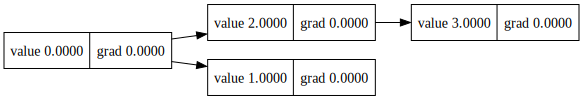

In [ ]:
draw_dot([root])

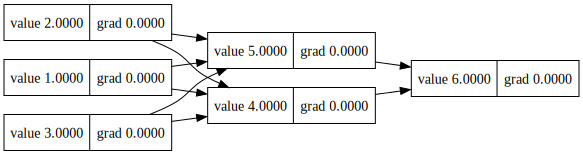

In [ ]:
draw_dot([in1,in2,in3])

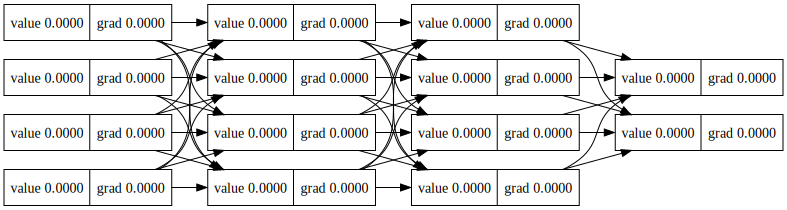

In [ ]:
draw_dot(NN.inputs)

# Expresion #
$a^{(1)}=\sigma (Wa^{(0)}+b)$

In [ ]:
A = np.array([[2, 4], [5, -6]])
B = np.array([[9, -3], [3, 6]])